In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from utils.evaluation import create_xarray,get_storm_coords
from utils.data import load_tc_data
from multiprocessing import Pool
import xesmf as xe
from global_land_mask import globe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

In [7]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',cmap='Blues',title='Accumulated Rainfall',levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<1,np.nan,data)
        lon2d,lat2d = np.meshgrid(lons,lats)
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        # ax.set_extent([-100,-30,5,45], crs=ccrs.PlateCarree())
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour)

        ax.outline_patch.set_linewidth(0.5)
        cbar = plt.colorbar(c, shrink=0.68)
        cbar.ax.tick_params(labelsize=6,width=0.5)

        tc_data = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

        for storm in basin_sids:
                storm_data = tc_data[tc_data['sid']==storm]
                storm_lats = storm_data['lat']
                storm_lons = storm_data['lon']
                plt.plot(storm_lons,storm_lats,linewidth=0.1,color='Black')
        ax.set_xlim(-100,-30)
        ax.set_ylim(5,45)
        plt.tight_layout()
        if plot=='show':
                plt.show()
        else:
                plt.savefig('basin_rainfall.png',bbox_inches='tight',dpi=300)

In [8]:
def find_basin_coords(basin):
	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	ds = xr.open_dataset(fp)
	if basin == 'NA':
		min_lon,min_lat,max_lon,max_lat = -100,5,-30,45
	elif basin == 'NIO':
		min_lon,min_lat,max_lon,max_lat = 40,5,110,30
	elif basin == 'NWP':
			min_lon,min_lat,max_lon,max_lat = 90,5,179,30
	elif basin == 'SPO':
			min_lon,min_lat,max_lon,max_lat = 130,-30,-110,-5
	elif basin == 'A':
			min_lon,min_lat,max_lon,max_lat = 70,-30,150,-5

	mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
	mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
	cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

	lats = cropped_ds.lat.values
	lons = cropped_ds.lon.values
	return lats,lons


In [9]:
def find_basin_tcs(meta,basin):
		"""
		Grabs all tcs that ever make landfall at tc strength

				inputs : meta csv
		"""
		nstorms,_ = meta.shape
		basin_sids = []
		if basin == 'NA':
			min_lon,min_lat,max_lon,max_lat = -100,5,-30,45
		elif basin == 'NIO':
			min_lon,min_lat,max_lon,max_lat = 40,5,110,30
		elif basin == 'NWP':
			min_lon,min_lat,max_lon,max_lat = 90,5,179,30
		elif basin == 'SPO':
			min_lon,min_lat,max_lon,max_lat = 130,-30,-110,-5
		elif basin == 'A':
			min_lon,min_lat,max_lon,max_lat = 70,-30,150,-5
		
		for i in range(nstorms):
				centre_lat = meta['centre_lat'][i]
				centre_lon = meta['centre_lon'][i]
				if centre_lon > 180:
						centre_lon = centre_lon - 180
				in_basin = (centre_lat >= min_lat) & (centre_lat <= max_lat) & (centre_lon >= min_lon) & (centre_lon <= max_lon)
				if in_basin:
						sid = meta['sid'][i]
						basin_sids.append(sid)

		# find indices of all basining snapshots
		basin_sids = list(dict.fromkeys(basin_sids))
		return basin_sids

In [10]:
# load data
real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_vaegan_ensemble,pred_gan_ensemble,meta = load_tc_data(set='test',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_test',results='test')
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')


In [11]:
# define basin
basin = 'NA'
lats,lons = find_basin_coords(basin)
basin_sids = find_basin_tcs(meta,basin)

# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in basin_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

all_sids = list(dict.fromkeys(meta['sid']))
grid_x, grid_y = np.meshgrid(lons, lats)


In [12]:

def computation(sid):
	# initialise accumulated xarray
	grid_x, grid_y = np.meshgrid(lons, lats)
	a = np.zeros((grid_y.shape))
	accumulated_ds = create_xarray(lats,lons,a)
	accumulated_ds_pred = create_xarray(lats,lons,a)

	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	sid = str(sid[0])

	for i in globals()['sid_%s' % sid]:
		# print('i is',i)
		
		storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)

		ds = create_xarray(storm_lats,storm_lons,real[i])
		ds_pred = create_xarray(storm_lats,storm_lons,pred_gan[i])

		# regrid so grids match
		regridder = xe.Regridder(ds, accumulated_ds, "bilinear")
		ds_out = regridder(ds)
		ds_pred_out = regridder(ds_pred)
		
		# add up rainfall
		accumulated_ds = accumulated_ds + ds_out
		accumulated_ds_pred = accumulated_ds_pred + ds_pred_out

		return accumulated_ds,accumulated_ds_pred

def process(df):
	# print('doing process...')
	res = df.apply(computation,axis=1)
	return res

if __name__ == '__main__':
	df = pd.DataFrame(basin_sids)
	# df = df[0]
	df_split = np.array_split(df, len(basin_sids))
	p = Pool(processes=len(basin_sids))
	print('pooling processes...')

	pool_results = p.map(process, df_split)
	print('results pooled')
	# result = sum(p)
	p.close()

	p.join()

print(pool_results)

pooling processes...
results pooled
[0    ([precipitation], [precipitation])
dtype: object, 1    ([precipitation], [precipitation])
dtype: object, 2    ([precipitation], [precipitation])
dtype: object, 3    ([precipitation], [precipitation])
dtype: object, 4    ([precipitation], [precipitation])
dtype: object, 5    ([precipitation], [precipitation])
dtype: object, 6    ([precipitation], [precipitation])
dtype: object, 7    ([precipitation], [precipitation])
dtype: object, 8    ([precipitation], [precipitation])
dtype: object, 9    ([precipitation], [precipitation])
dtype: object, 10    ([precipitation], [precipitation])
dtype: object, 11    ([precipitation], [precipitation])
dtype: object, 12    ([precipitation], [precipitation])
dtype: object, 13    ([precipitation], [precipitation])
dtype: object, 14    ([precipitation], [precipitation])
dtype: object, 15    ([precipitation], [precipitation])
dtype: object, 16    ([precipitation], [precipitation])
dtype: object, 17    ([precipitation

In [13]:
print(len(pool_results))
print(pool_results[1][1])

53
(<xarray.Dataset>
Dimensions:        (x: 700, y: 400)
Coordinates:
    lon            (x) float32 -99.95 -99.85 -99.75 ... -30.25 -30.15 -30.05
    lat            (y) float32 5.05 5.15 5.25 5.35 ... 44.65 44.75 44.85 44.95
Dimensions without coordinates: x, y
Data variables:
    precipitation  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0, <xarray.Dataset>
Dimensions:        (x: 700, y: 400)
Coordinates:
    lon            (x) float32 -99.95 -99.85 -99.75 ... -30.25 -30.15 -30.05
    lat            (y) float32 5.05 5.15 5.25 5.35 ... 44.65 44.75 44.85 44.95
Dimensions without coordinates: x, y
Data variables:
    precipitation  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0)


In [14]:

grid_x, grid_y = np.meshgrid(lons,lats)
a = np.zeros((grid_y.shape))
accumulated_ds = create_xarray(lats,lons,a)
accumulated_ds_pred = create_xarray(lats,lons,a)

for i in range(len(pool_results)):
	if pool_results[i][i] == None:
		continue
	accumulated_ds = accumulated_ds + pool_results[i][i][0]
	accumulated_ds_pred = accumulated_ds_pred + pool_results[i][i][1]


print(accumulated_ds)

<xarray.Dataset>
Dimensions:        (x: 700, y: 400)
Coordinates:
    lon            (x) float32 -99.95 -99.85 -99.75 ... -30.25 -30.15 -30.05
    lat            (y) float32 5.05 5.15 5.25 5.35 ... 44.65 44.75 44.85 44.95
Dimensions without coordinates: x, y
Data variables:
    precipitation  (y, x) float64 0.0625 0.0 0.0625 0.0625 ... 0.0 0.0 0.0 0.0


In [15]:
levels = [0,10,20,30,40,50,60,70,80,90,100]
centre_lats=None
centre_lons = None
intensity = None
tc_data = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
for storm in basin_sids:
	storm_data = tc_data[tc_data['sid']==storm]
	storm_lats = storm_data['lat']
	storm_lons = storm_data['lon']

# plot_accumulated(accumulated_ds['precipitation'],accumulated_ds['lat'].values,accumulated_ds['lon'].values,vmin=0,vmax=100,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
# plot_accumulated(accumulated_ds_pred['precipitation'],accumulated_ds_pred['lat'].values,accumulated_ds_pred['lon'].values,vmin=0,vmax=100,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)



In [16]:
grid_x, grid_y = np.meshgrid(accumulated_ds['lon'].values, accumulated_ds['lat'].values)
land = globe.is_land(grid_y,grid_x)

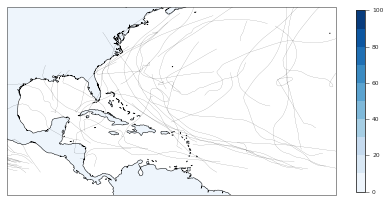

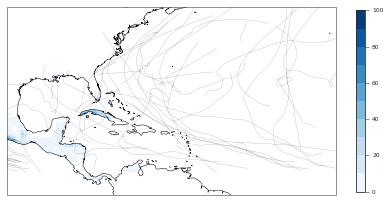

In [17]:
plot_accumulated(land,accumulated_ds_pred['lat'].values,accumulated_ds_pred['lon'].values,vmin=0,vmax=100,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
pred_land = accumulated_ds_pred['precipitation'].values
pred_land[~land] = 0
plot_accumulated(pred_land,accumulated_ds_pred['lat'].values,accumulated_ds_pred['lon'].values,vmin=0,vmax=100,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)


In [18]:
print(pred_gan_ensemble.shape)

(16007, 100, 100, 20)
